# Label Component Unfolding (LCU)

O algoritmo LCU é um sistema dinâmico que pode ser aplicado numa rede complexa para resolver problemas semi-supervisionados. Seu funcionamento espelha-se em comportamentos da natureza e sistemas sociais, como sobrevivência, competição por recursos, exploração territorial e campanhas de eleição.

O autor desse algoritmo é brasileiro, Dr. Filipe Verri (ITA), sendo publicado como um artigo no IEEE e componente da sua tese de doutorado *Collective dynamics in complex networks for machine learning* (2018).

Diferentes de modelos de machine learning mais conhecidos, indutivos, onde há uma etapa prévia de aprendizado e então outra de predição, este algoritmo é classificado **transdutivo**: o aprendizado ocorre de maneira indireta enquanto a predição é feita! Ocorre uma etapa única, iterativa, de classificação.

Nessa camada de resolução do problema, já precisamos ter uma rede complexa formada e uma função de extração de características $ f(X) $, onde $ X $ são os dados de entrada do sistema.

In [1]:
# ref: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut, cat, microaneurysms, rocket
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import networkx as nx

from egsis.complex_networks import complex_network_from_segments
from egsis.complex_networks import draw_complex_network
from egsis.superpixels import build_superpixels_from_image
from egsis.superpixels import superpixel_centroids

# Gerar Superpixels

(-0.5, 639.5, 426.5, -0.5)

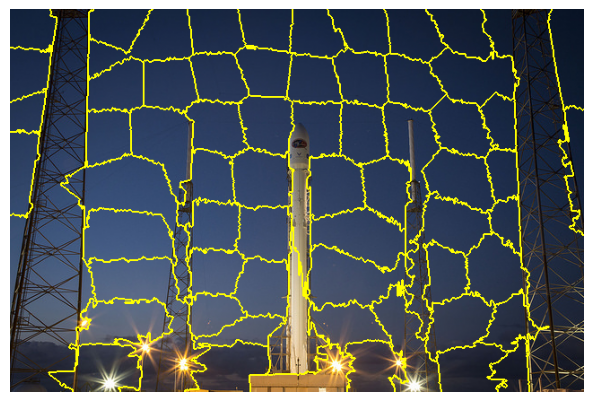

In [93]:
img = img_as_float(rocket())
superpixels = build_superpixels_from_image(img, compactness=5)
ax = plt.imshow(mark_boundaries(img, superpixels))
plt.tight_layout()
plt.axis('off')

# Gerar Rede Complexa

(-51.785000000000004, 694.7850000000001, 449.95, -0.5)

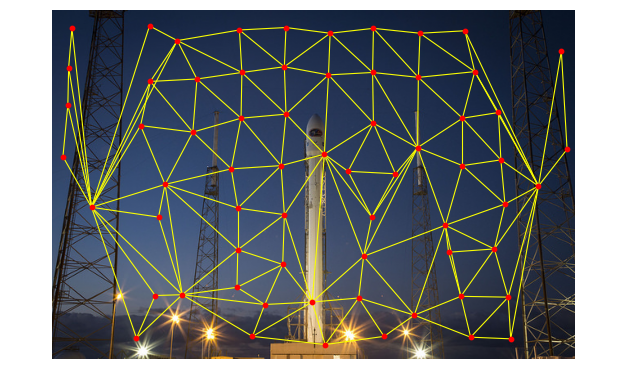

In [94]:
complex_network = complex_network_from_segments(superpixels)
centroids = superpixel_centroids(superpixels)
plt.imshow(img)
draw_complex_network(complex_network, superpixels)
plt.tight_layout()
plt.axis('off')

In [4]:
nx.adjacency_matrix(complex_network)

/tmp/ipykernel_1434622/2393886543.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(complex_network)


<75x75 sparse matrix of type '<class 'numpy.int64'>'
	with 372 stored elements in Compressed Sparse Row format>

In [16]:
complex_network.degree[21]

11

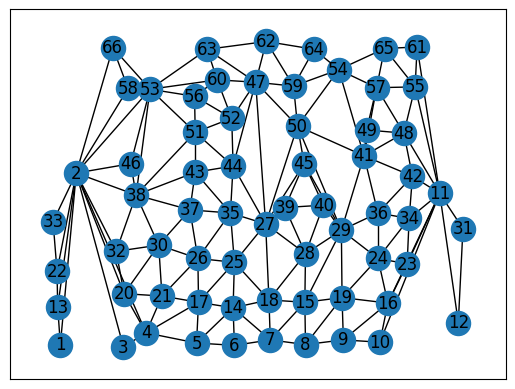

In [95]:
nx.draw_networkx(complex_network, pos=superpixel_centroids(superpixels))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


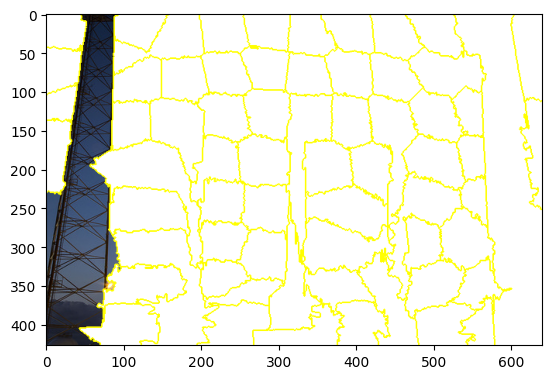

In [96]:
img_copy = img.copy()
img_copy[superpixels != 2] = 255
plt.imshow(mark_boundaries(img_copy, superpixels))

In [47]:
from egsis import features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


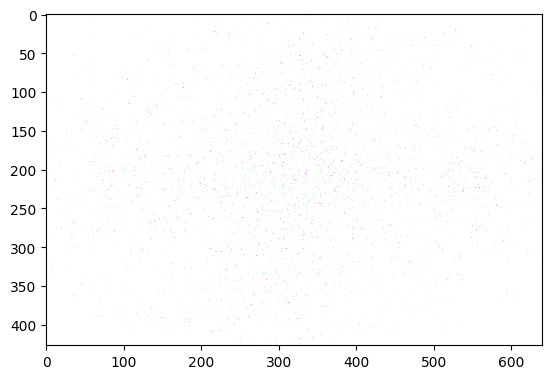

In [97]:
segment = features.get_segment_using_label(img, superpixels, 2)
plt.imshow(abs(np.fft.fftshift(features.feature_extraction(segment))))

In [76]:
import imp
imp.reload(features)

<module 'egsis.features' from '/home/lerax/Dropbox/University/TCC/egsis/egsis/features.py'>

In [100]:
x1 = features.feature_extraction_segment(img, superpixels, 2)
x2 = features.feature_extraction_segment(img, superpixels, 10)

print(features.euclidian_distance(x1, x2))

73144.96587387403
